# Who voted what?
## A dive into the Colombia's peace plebiscite outcome

**_by Gabriel Vizcaino Sanchez_**

October, 2016. (Tutorial written for the _Practical Data Science_ graduate course at Carnegie Mellon University)

Last October 2th was a milestone in the Colombian history. On that Sunday, Colombians casted votes approving or rejecting the peace agreement signed between the official government and FARC guerrilla. The outcome came as a setback to pollsters’ predictions as the negative vote prevailed by a razor-thin margin of 50.21% to 49.78%, leaving the country immersed in a massive sea of uncertainty. This plebiscite was important since the peace accord represents an opportunity to halt an armed conflict prolonged for over 50 years, which so far has left the an estimated of 218,000 people killed, 27,000 kidnappings, 5.7 million forced displacements and many more human rights violations and war crimes (see plot below).

In this tutorial, the results from the plebiscite are collected, processed and analyzed.  This dataset is mingled with adjacent country statistics (e.g. poverty rate and conflict impact region-wise) to answer insightful questions and draw some conclusions using data analytics techniques in Python. 

[<img src="https://www.wola.org/files/images/1402confl.png" width="600">](https://www.wola.org/files/images/1402confl.png)

The tutorial is organized as follows:
- [A little background](#A-little-background)
- [Setting up the data](#Setting-up-the-data)
- [How did "YES/"NO" votes distribute?](#How-did-"YES/"NO"-votes-distribute?)
- [What did the most vulnerable regions vote?](#What-did-the-most-vulnerable-regions-vote?)
- [A rejection of the peace agreement or a vote against Pt. Santos?](#A-rejection-of-the-peace-agreement-or-a-vote-against-Pt.-Santos?)
- [Did people actually vote?](#Did-people-actually-vote?)
- [Main takeaways](#Main-takeaways)
- [References](#References)

## A little background

FARC is the oldest and largest a guerrilla in Latin America. This leftist group is known for employing a variety of military tactics including terrorism, children recruitment and sexual assault, among other unconventional methods.  Colombian governments have been committed to combat this group historically in order to protect the population and civil infrastructure. Not surprisingly, the poorest regions of the country have suffered the most the fallouts from this conflict. 

Attempts to negotiate with FARC have been undertaken in the past with unsuccessful results. On August 2012, the government of President Juan Manuel Santos embarked in a new negotiation with FARC seeking to terminate this conflict once and for all. After four years of negations both parties crafted an agreement, the first ever reached, which renders a true possibility to end this half-century-long warfare.  

To boost public support and preserve legitimacy, President Santos promised to give people the opportunity to back or reject the accord through this plebiscite. Voters were asked a single question in the ballot:

_**“Do you support the final accord to end the conflict and build a stable and lasting peace?”**_

The possible answers were: **“YES”** or **“NO”**. _Any other answers would make the vote invalid_. For further information about the conflict and peace agreement in Colombia, please refer to the links in [References](#References).

## Setting up the data

A web scraper was programmed to extract the data since results from the plebiscite are available in the form of infrographics at the [Colombia's National Registry website](http://plebiscito.registraduria.gov.co/99PL/DPLZZZZZZZZZZZZZZZZZ_L1.htm). The country is divided in 32 regions plus the Capital District. Here, the international consulates are treated as a region, then totaling 34 regions. Furthermore, regions are divided into cities and municipalities - for the sake of simplicity,  _municipality_ will refer to both categories. There are 1,092 municipalities in the database (including 58 international consulates).

The following python libraries are used in this tutorial:

In [2]:
import numpy as np, math, requests, re, pandas as pd, json, geopandas as gpd
import matplotlib, shapely, rtree, matplotlib.pyplot as plt, seaborn as sns
from bs4 import BeautifulSoup
from scipy.stats import norm
from geopy.geocoders import GoogleV3
from read_presidential2014 import data_pres2014
from read_plebiscite2016 import data_plebiscite2016
%matplotlib inline
matplotlib.rc("figure", figsize=(8,6));matplotlib.rc("axes", labelsize=16, titlesize=16)
matplotlib.rc("xtick", labelsize=14);matplotlib.rc("ytick", labelsize=14)
matplotlib.rc("legend", fontsize=14);matplotlib.rc("font", size=14);sns.set()

Regional and municipal results are in different `url` addresses with an standardized HTML format. Data is collected by calling the `data_plebiscite2016` function which iterates through the websites, and using `BeautifulSoup and regular expressions`, it scrapes the data and fills up two dictionaries: `regions` and `munis`, representing regions and municipalities respectively. These dictionaries are later transformed into two dataframes: `df_regions` and `df_munis`, which are the returning variables of the function. In the dataframes, rows list the different regions/municipalities and columns correspond to the features (e.g. null votes, total votes, "YES" votes).

Likewise, results from both rounds of presidential election in 2014 are available in a similar format at this [website](http://www3.registraduria.gov.co/elecciones/elecciones2014/presidente/1v/99PR1/DPR9999999_L1.htm). Employing the same strategy just described, the function `data_pres2014` retrives the data for either round in two dataframes as well.

These fuctions are available in my github repository ([gvizcaino](https://github.com/gvizcaino/Tutorial)).

In [ ]:
# Extracting data of the 2016 Colombian peace plebiscite
df_regions,df_munis = data_plebiscite2016()

# Extracting data of the 2014 Colombian presidential election
_,df_regions14_1,df_munis14_1,_ = data_pres2014(1) # First round
_,df_regions14_2,df_munis14_2,_ = data_pres2014(2) # Second round

Additional data is incorporated to enhance the analysis. While a comprehensive assessment should consider a swath of socio-economic factors, given the scope of this tutorial and the availability of data, the present analysis only includes three additional factors:
- _Poverty:_ The latest estimations of economic poverty rate per region were downloaded from the National Statistics Department ([DANE](https://www.dane.gov.co/index.php/estadisticas-por-tema/pobreza-y-condiciones-de-vida/pobreza-y-desigualdad)) statistics database.
-  _Violence intensity index:_ The map in this [link](http://www.kienyke.com/politica/las-zonas-de-mas-violencia-en-colombia) prepared by the Humanitarian Attention Unit (OCHA, acronym in Spanish), resumes the violent events occurred during 2012-2013 related to the armed conflict by region. A _violence index_ was computed by dividing the number of violent events into the total voters per region. These values were further normalized by setting the region with the highest score as “1” and then scaling the others accordingly. 
- _Vulnerability index:_ The [Foundation of Peace and Reconciliation]( http://www.pares.com.co/) has identified the municipalities most vulnerable to relapse into violence in a post-peace-agreement scenario given the historical strong presence of armed illegal groups. This [map]( http://www.las2orillas.co/wp-content/uploads/2015/02/mapa-.png) classifies the municipalities in four categories of vulnerability: _Low, Medium, High and Extreme_.

In [4]:
# Load and incorporate information in terms of poverty rate, income per capita and number of violent events per region
v_events = pd.read_csv(r'regional_data.csv',encoding='utf8'); v_events.set_index('Reg', inplace = 'True')
df_regions = df_regions.join(v_events)

# Load and incorporate information in terms conflict vulnerability index per municipality/city
vulner = pd.read_csv(r'vulnerability_index.csv',encoding='utf8'); vulner.set_index('muni', inplace = 'True');
df_munis = df_munis.join(vulner)

# Useful calculations
df_regions['yes_no_ratio'] = df_regions["yes_votes_p"]/df_regions["no_votes_p"]
df_munis['yes_no_ratio'] = df_munis["yes_votes_p"]/df_munis["no_votes_p"]
df_regions['elec_part'] = df_regions["voters"]/df_regions["total_voters"]
df_munis['elec_part'] = df_munis["voters"]/df_munis["total_voters"]
temp = (df_regions["v_events"]/df_regions["total_voters"]); temp = temp/max(temp);df_regions['conflict'] = temp;df_regions.head()

,total_voters,null_votes,valid_votes,yes_votes,voters,unmarked_votes,no_votes_p,yes_votes_p,no_votes,v_events,poverty,income,yes_no_ratio,elec_part,conflict
AMAZONAS,44795,114,11518,6524,11714,82,0.4335,0.5664,4994,0,0.278,590826.0,1.306574,0.261502,0.000000
ANTIOQUIA,4539316,22416,1705569,648051,1742139,14154,0.6200,0.3799,1057518,591,0.237,674887.0,0.612742,0.383789,0.070109
ARAUCA,176625,1523,58927,28653,61088,638,0.5137,0.4862,30274,328,0.278,590826.0,0.946467,0.345863,1.000000
ATLANTICO,1788211,2132,426421,258121,430989,2436,0.3946,0.6053,168300,64,0.257,542223.0,1.533958,0.241017,0.019273
BOGOTA DC,5547172,25213,2538545,1423612,2570359,6601,0.4392,0.5607,1114933,73,0.104,989329.0,1.276639,0.463364,0.007086


## How did "YES/"NO" votes distribute?
To get a sense upon how Colombians voted overall, Figures 1 and 2 show the histograms and main statistics of "YES" and "NO" votes participation across municipalities, respectively. It is worth to highlight that the **"NO" votes won by a very tight margin of 24,213 votes (less than 0.2% of total votes)**. The histograms approximate to a triangular distribution in both categories, with mode around 55% for "NO" and 45% for "YES", although the average share of "YES" votes was higher. Interestingly, the standard deviation was the same in both cases, however, the coefficient of variation was higher for the "NO" meaning the it slightly variated more across the territory.

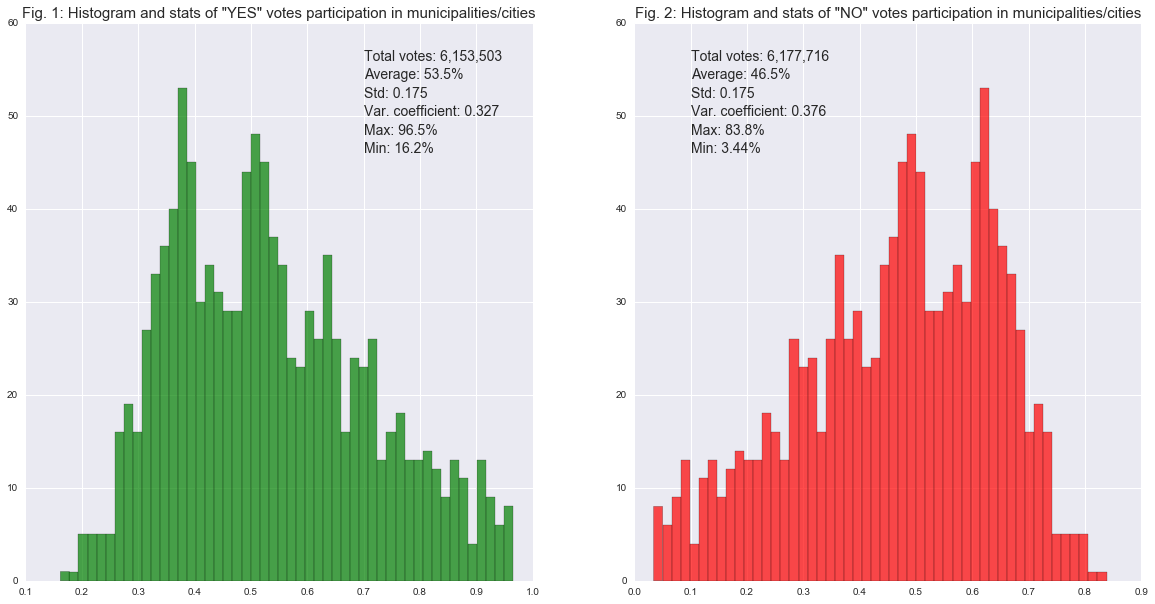

In [137]:
# Generations histograms and descriptive statistics of "Yes" and "No" votes
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
axes[0].hist(df_munis['yes_votes_p'],color='g',bins=50,alpha=0.7)
axes[0].text(0.7,56,r'Total votes: {:,}'.format(np.sum(df_munis['yes_votes'])),fontsize=14)
axes[0].text(0.7,54,r'Average: {0:.3g}%'.format(np.mean(df_munis['yes_votes_p'])*100),fontsize=14)
axes[0].text(0.7,52,r'Std: {0:.3g}'.format(np.std(df_munis['yes_votes_p'])),fontsize=14)
axes[0].text(0.7,50,r'Var. coefficient: {0:.3g}'.format(
        np.std(df_munis['yes_votes_p'])/np.mean(df_munis['yes_votes_p'])),fontsize=14)
axes[0].text(0.7,48,r'Max: {0:.3g}%'.format(np.max(df_munis['yes_votes_p'])*100),fontsize=14)
axes[0].text(0.7,46,r'Min: {0:.3g}%'.format(np.min(df_munis['yes_votes_p'])*100),fontsize=14)
axes[0].set_title('Fig. 1: Histogram and stats of "YES" votes participation in municipalities/cities',fontsize=15)
axes[1].hist(df_munis['no_votes_p'],color='r',bins=50,alpha=0.7);
axes[1].text(0.1,56,r'Total votes: {:,}'.format(np.sum(df_munis['no_votes'])),fontsize=14)
axes[1].text(0.1,54,r'Average: {0:.3g}%'.format(np.mean(df_munis['no_votes_p'])*100),fontsize=14)
axes[1].text(0.1,52,r'Std: {0:.3g}'.format(np.std(df_munis['no_votes_p'])),fontsize=14)
axes[1].text(0.1,50,r'Var. coefficient: {0:.3g}'.format(
        np.std(df_munis['no_votes_p'])/np.mean(df_munis['no_votes_p'])),fontsize=14)
axes[1].text(0.1,48,r'Max: {0:.3g}%'.format(np.max(df_munis['no_votes_p'])*100),fontsize=14)
axes[1].text(0.1,46,r'Min: {0:.3g}%'.format(np.min(df_munis['no_votes_p'])*100),fontsize=14)
axes[1].set_title('Fig. 2: Histogram and stats of "NO" votes participation in municipalities/cities',fontsize=15);

Data from Figures 1 and 2 show that even though on average Colombians voted favorably at the municipal level, the amount of "YES" votes gathered in pro-peace-agreement regions was not enough to outweigh the negative votes in the regions of opposition overall.

## What did the most vulnerable regions vote?
Considering that the armed conflict with FARC has spread geographically in an asymmetric fashion, there are zones largely more affected than others. Therefore, it is worthwhile to find out what is the stand of people directly impacted by this conflict with regards to the peace agreement. A geospatial visualization comes handy in order to analyze variables that are geographically related. Using [`Geopandas`](http://geopandas.org/index.html) package and the [`geojson` map of Colombia](https://bl.ocks.org/john-guerra/43c7656821069d00dcbc), Figures 3 and 4 are generated to illustrate the ratio of YES/NO votes as well as the violence intensity index region-wise, respectively. 

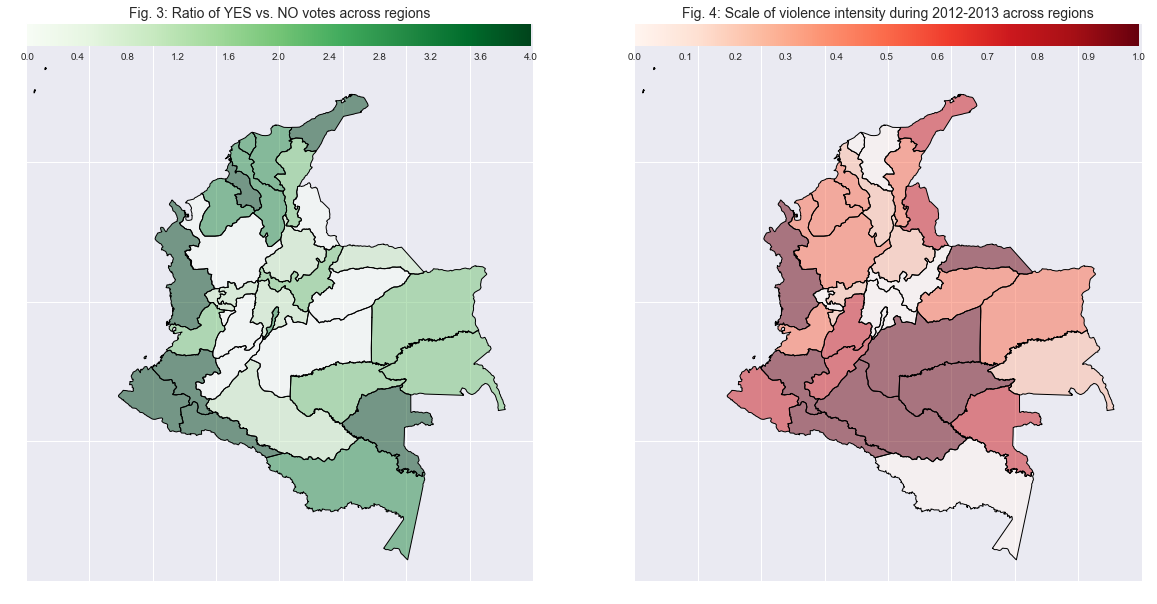

In [16]:
# Importing geojson file containing Colombian coordinates and merging data from df_regions
geo_regions = gpd.read_file('Colombia.geo.json.txt')
geo_regions.set_index('NOMBRE_DPT', inplace = True)
geo_regions = geo_regions.join(df_regions.loc[:,['yes_no_ratio','conflict']],how='inner')

# Map plot of YES/NO ratios and violence index across Colombia
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
ax1 = geo_regions.plot(column='yes_no_ratio', scheme='quantiles',figsize = (10,10),cmap='Greens',ax=axes[0]);
ax1.tick_params(axis='x', colors='white');ax1.tick_params(axis='y', colors='white')
ax1.set_title('Fig. 3: Ratio of YES vs. NO votes across regions',fontsize=14)
fig1 = ax1.get_figure();cax = fig1.add_axes([0.126, 0.868, 0.35, 0.03])
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=4, vmax=0)); sm._A = []
fig1.colorbar(sm, cax=cax, orientation='horizontal')
ax2 = geo_regions.plot(column='conflict', scheme='quantiles',figsize = (10,10),cmap='Reds',ax=axes[1]);
ax2.tick_params(axis='x', colors='white');ax2.tick_params(axis='y', colors='white')
ax2.set_title('Fig. 4: Scale of violence intensity during 2012-2013 across regions',fontsize=14)
fig2 = ax2.get_figure();cax = fig2.add_axes([0.548, 0.868, 0.35, 0.03])
sm2 = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=1, vmax=0)); sm2._A = []
cb2 = fig2.colorbar(sm2, cax=cax, orientation='horizontal')

At the regional level, a modest positive correlation between the two variables plotted could be grasped by visually contrasting Figures 3 and 4. In regions like the West-coast and the South-west, where the intensity of violent events is high, "YES" votes outweighed "NO" votes by a factor of 2x to 4x. However, there are some regions highly affected by violence as well, like the Mid-south and Mid-north, where "NO" votes prevailed. To dig deeper into this issue, the data could be also correlated with the vulnerability index at the municipal level. The following script generates Figure 5 which presents the average and standard deviation of “YES” and “NO” voting participation in municipalities classified by vulnerability category.    

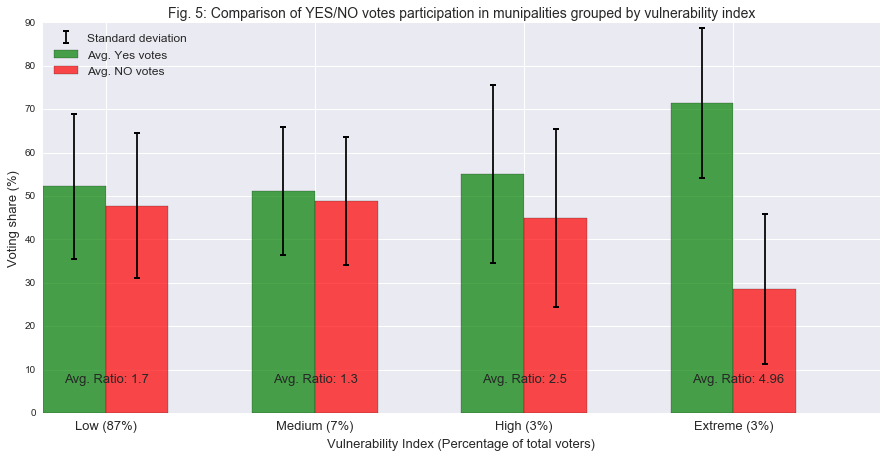

In [211]:
# Erorbar plot for YES/NO votes participation in munipalities grouped by vulnerability index
plt.figure(figsize=(15,7)); df_munis_gv = df_munis.groupby(['vulner_idx']);leng = np.arange(len(df_munis_gv)); wd = 0.3
yes_means = df_munis_gv['yes_votes_p'].mean()*100; yes_stds = df_munis_gv['yes_votes_p'].std()*100
no_means = df_munis_gv['no_votes_p'].mean()*100; no_stds = df_munis_gv['no_votes_p'].std()*100
plt.bar(leng,yes_means.values,wd,color='g',yerr=yes_stds.values,error_kw=dict(ecolor='black',capthick=2,label=''),alpha=0.7)
plt.bar(leng+wd,no_means.values,wd,color='r',yerr=no_stds.values, error_kw=dict(ecolor='black',capthick=2),alpha=0.7)
plt.ylabel('Voting share (%)',fontsize = 13);plt.xlabel('Vulnerability Index (Percentage of total voters)',fontsize = 13);
plt.legend(['Standard deviation','Avg. Yes votes','Avg. NO votes'],fontsize = 12,loc=2)
plt.title('Fig. 5: Comparison of YES/NO votes participation in munipalities grouped by vulnerability index',fontsize = 14)
vot = df_munis_gv['voters'].sum()/np.sum(df_munis['voters'])*100
plt.xticks(leng+wd); plt.xticks(leng+wd,
                                ('Low ({0:.2g}%)'.format(vot[0]),'Medium ({0:.1g}%)'.format(vot[1]),
                                 'High ({0:.1g}%)'.format(vot[2]+1), 'Extreme ({0:.1g}%)'.format(vot[3])),fontsize = 13);
mm = df_munis_gv['yes_no_ratio'].mean(); 
plt.text(0.1,7,r'Avg. Ratio: {:,.2g}'.format(mm[0]),fontsize = 13);plt.text(1.1,7,r'Avg. Ratio: {:,.2g}'.format(mm[1]),fontsize = 13)
plt.text(2.1,7,r'Avg. Ratio: {:,.2g}'.format(mm[2]),fontsize = 13);plt.text(3.1,7,r'Avg. Ratio: {:,.3g}'.format(mm[3]),fontsize = 13);

Figure 5 conveys a conclusive message: **Colombians living in _High_ and _Extreme_ vulnerable municipalities across the country remarkably supported the peace agreement in the ballot**. This means that victims who unfortunately have suffered the most the stark consequences of this war (e.g. massacres, land snatched, child recruitment), were, and most likely still are, willing to back the government efforts to terminate this long-lasting armed conflict. However, the population in these zones only represents 6% of voters, therefore, people living in the least vulnerable regions were the ones who actually made the final decision. While the average YES/NO ratio was also greater than one in Low and Medium vulnerable municipalities, negative votes casted primarily in the country’s center (i.e. mainly urban areas) slightly surpassed the positive scenario portrayed specially in vulnerable zones (i.e. mainly rural areas).

Furthermore, the YES/NO ratio is also correlated with data of poverty and electoral participation (i.e. voters/total_voters). Figure 6 and 7 illustrate this relation at the regional level for both variables respectively. **There is a positive correlation between the ratio of YES/NO votes and the poverty rate per region**. Though more data is needed to better feature this relation (e.g. at the munucipal level), this preliminary result is coherent with former claims, as people in least favorable regions from a socio-economic standpoint (e.g. rural areas or low income cities), were keener towards the agreement than people living in areas whit lower poverty rates. On the other hand, the YES/NO ratio also renders a negative correlation with the electoral participation, meaning that as votes grew in magnitude the negative share strengthened.

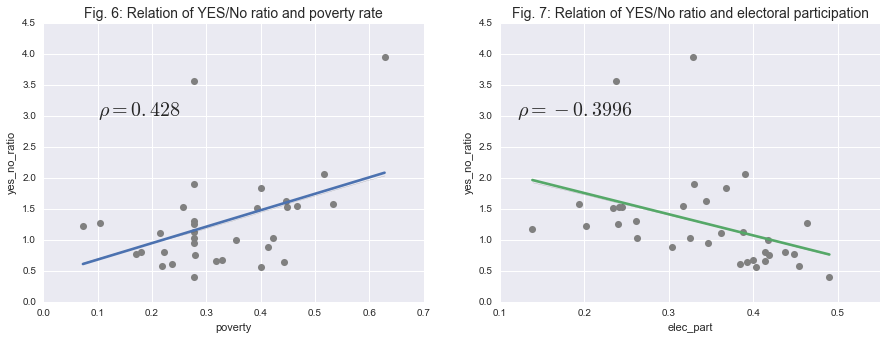

In [16]:
rho = df_regions.corr(method='pearson');fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax1=sns.regplot(x='poverty',y='yes_no_ratio',data=df_regions,ci=False,
                scatter_kws={"s": 50, "alpha": 1,'color':'grey'},ax=axes[0],truncate=True)
ax1.text(0.1,3,r'$\rho = {0:.3g}$'.format(rho['yes_no_ratio'][10]),fontsize=20);
ax1.set_title('Fig. 6: Relation of YES/No ratio and poverty rate',fontsize=14)
ax2=sns.regplot(x='elec_part',y='yes_no_ratio',data=df_regions,ci=False,
                scatter_kws={"s": 50, "alpha": 1,'color':'grey'},ax=axes[1],truncate=True)
ax2.text(0.12,3,r'$\rho = {0:.4g}$'.format(rho['yes_no_ratio'][13]),fontsize=20);
ax2.set_title('Fig. 7: Relation of YES/No ratio and electoral participation',fontsize=14);

## A rejection of the peace agreement or a vote against Pt. Santos?
Data suggest that the latter option of this two-part question seems to be more accurate. To identify how Colombians voted given their political affiliation or support/disapproval of the government in-office, an approximation could be made by comparing the outcome of the plebiscite with the results of the second round of the presidential election in 2014. In that election, current President Juan M. Santos ran against the candidate of the "Centro Democratico" party, Oscar Ivan Zuluaga. Centro Democratico is the most visible party in the opposition to the current government and also to the peace agreement with FARC. Figure 8 to 11 show the relation of "NO" votes participation versus the voting share of President Santos and Oscar Zuluaga in the second round of the 2014 presidential election at regional and municipal level.

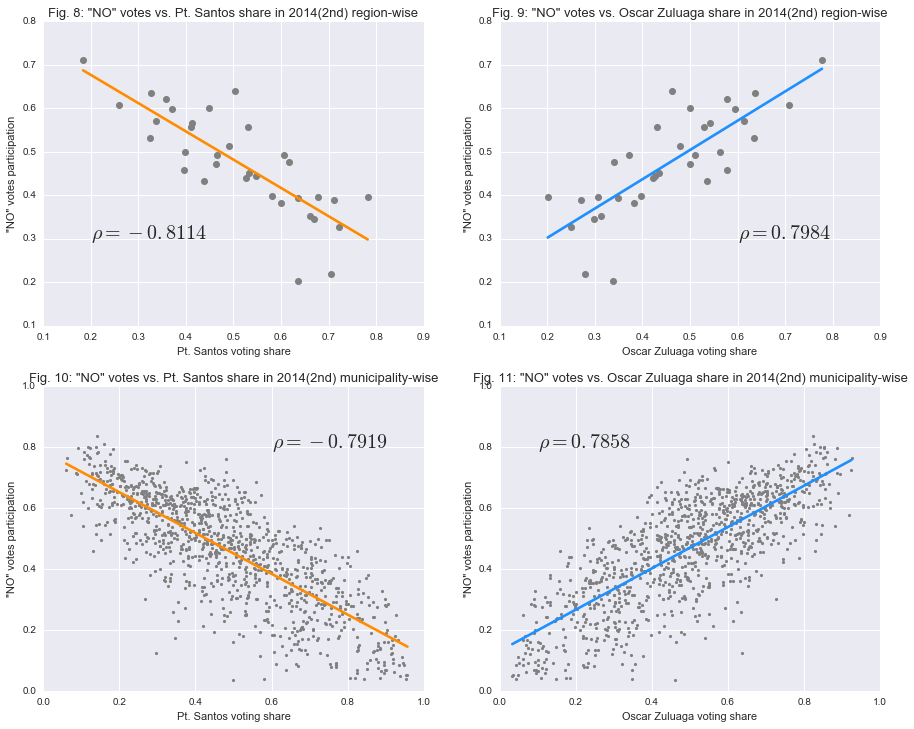

In [5]:
# Incorporating data from 2014 elections
df_regions = df_regions.join(df_regions14_1).join(df_regions14_2)
df_munis14_2.drop(['url','region'],axis=1,inplace=True)
df_munis14_1.drop(['url','region'],axis=1,inplace=True)
df_munis = df_munis.join(df_munis14_1).join(df_munis14_2)

# Generating scatter plots
rho = df_regions.corr(method='pearson');
rho_munis = df_munis.corr(method='pearson');
fig,axes = plt.subplots(nrows=2, ncols=2,figsize=(15,12))
ax1 = sns.regplot(x='UN_votes_p14_2',y='no_votes_p',data=df_regions,ci=False, color='darkorange',
            scatter_kws={"s": 50, "alpha": 1,'color':'grey'},ax=axes[0,0],fit_reg=True,truncate=True)
ax1.set_title('Fig. 8: "NO" votes vs. Pt. Santos share in 2014(2nd) region-wise',fontsize = 13)
ax1.set_xlabel('Pt. Santos voting share'); ax1.set_ylabel('"NO" votes participation')
ax1.text(0.2,0.3,r'$\rho = {0:.4g}$'.format(rho['no_votes_p']['UN_votes_p14_2']),fontsize=20);
ax2 = sns.regplot(x='CD_votes_p14_2',y='no_votes_p',data=df_regions,ci=False, color='dodgerblue',
            scatter_kws={"s": 50, "alpha": 1,'color':'grey'},ax=axes[0,1],truncate=True);
ax2.set_title('Fig. 9: "NO" votes vs. Oscar Zuluaga share in 2014(2nd) region-wise',fontsize = 13)
ax2.set_xlabel('Oscar Zuluaga voting share'); ax2.set_ylabel('"NO" votes participation');
ax2.text(0.6,0.3,r'$\rho = {0:.4g}$'.format(rho['no_votes_p']['CD_votes_p14_2']),fontsize=20);
ax3 = sns.regplot(x='UN_votes_p14_2',y='no_votes_p',data=df_munis,ci=False, color='darkorange',
            scatter_kws={"s": 10, "alpha": 1,'color':'grey'},ax=axes[1,0],fit_reg=True,truncate=True)
ax3.set_title('Fig. 10: "NO" votes vs. Pt. Santos share in 2014(2nd) municipality-wise',fontsize = 13);
ax3.set_xlim([0,1]); ax3.set_xlabel('Pt. Santos voting share'); ax3.set_ylim([0,1]); ax3.set_ylabel('"NO" votes participation')
ax3.text(0.6,0.8,r'$\rho = {0:.4g}$'.format(rho_munis['no_votes_p']['UN_votes_p14_2']),fontsize=20);
ax4 = sns.regplot(x='CD_votes_p14_2',y='no_votes_p',data=df_munis,ci=False, color='dodgerblue',
            scatter_kws={"s": 10, "alpha": 1,'color':'grey'},ax=axes[1,1],truncate=True);
ax4.set_title('Fig. 11: "NO" votes vs. Oscar Zuluaga share in 2014(2nd) municipality-wise',fontsize = 13);
ax4.set_xlim([0,1]); ax4.set_xlabel('Oscar Zuluaga voting share'); ax4.set_ylim([0,1]); ax4.set_ylabel('"NO" votes participation');
ax4.text(0.1,0.8,r'$\rho = {0:.4g}$'.format(rho_munis['no_votes_p']['CD_votes_p14_2']),fontsize=20);

**There is a remarkable linear and negative correlation between the "NO" votes and the voting share of Pt. Santos in the second round of 2014 elections. This high negative correlation is consistent at both regional and municipal levels.** This observation means that towns where Juan M. Santos didn’t do well in 2014 largely voted against the accord and vice versa. Consequently, regions where Oscar Zuluaga had a large voting share in 2014 also massively marked "NO" in the ballot. 

This pattern is not surprising given that the flagship of Pt. Santos' re-election champaign was the signature of this peace agreement with FARC; therefore, people who voted for him back then were very likely to also vote in favor of the peace agreeement this time. However, what is interesting is to check how Pt. Santos and the coalition parties did in convincing and bringing more people on board of the peace-agreement boat. To do this, it is worthwhile to assess in which regions/municipalities Pt. Santos, and the pro-agreement parties, "gained" or "lost" votes in the peace ballot relative to the voting share of Pt. Santos in the 2nd round of 2014 election. Figure 12 presents the histogram of the difference between "YES" votes (percentage) and the participation of votes for Pt. Santos in 2014 at the municipal level.

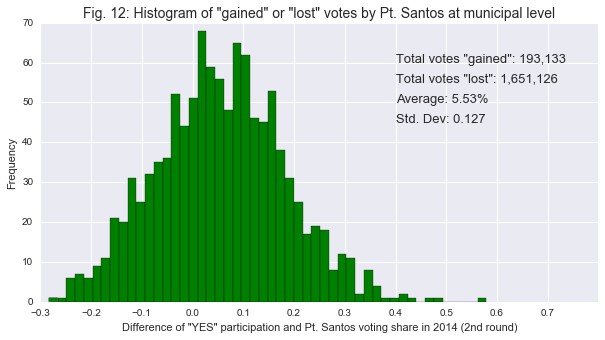

In [275]:
# Histogram of the votes "gained" or "lost" by Pt. Santos at municipal level
df_munis['delta'] = (df_munis['yes_votes_p']-df_munis['UN_votes_p14_2'])
total_delta = df_munis['yes_votes']-df_munis['UN_votes14_2']
plt.figure(figsize=(10,5))
ax = df_munis['delta'].plot(kind='hist',bins=50,color='g'); ax.set_xticks(np.arange(-0.3,0.8,0.1)); ax.set_xlim([-0.3,0.8]);
ax.set_title('Fig. 12: Histogram of "gained" or "lost" votes by Pt. Santos at municipal level',fontsize=14)
ax.set_xlabel('Difference of "YES" participation and Pt. Santos voting share in 2014 (2nd round)')
ax.text(0.4,60,r'Total votes "gained": {:,}'.format(int(np.sum(total_delta[total_delta>=0]))),fontsize=13)
ax.text(0.4,55,r'Total votes "lost": {:,}'.format(int(-np.sum(total_delta[total_delta<0]))),fontsize=13)
ax.text(0.4,50,r'Average: {0:.3g}%'.format(np.mean(df_munis['delta'])*100),fontsize=13)
ax.text(0.4,45,r'Std. Dev: {0:.3g}'.format(np.std(df_munis['delta'])),fontsize=13);

**On average Pt. Santos and the coalition parties gained 5.53% of voting share from 2014 to date at municipal level. However, this positive average is misleading because in magnitude, more than 1.6 million votes were "lost" in the peace ballot compared to the 2014 election, while only about 193,000 votes were gained.** The reason for this mixed result is that municipalities featuring a positive difference represent a little percentage of the total national votes; whereas municipalities with a negative difference hold a bigger chunk of the total votes. Moreover, since both ballots don't have the same base of _voters_ (electoral participation actually went down from 45% in 2014 to 37% today), and _blank voting_ wasn't an option in the peace ballot, it is actually possible that in some municipalities the difference was positive percentage-wise but negative in magnitude. To illustrate this pattern graphically, Figures 13 and 14 present the difference between "YES" votes and votes for Pt. Santos in 2014 region-wise, in both, percentage and magnitude, respectively.

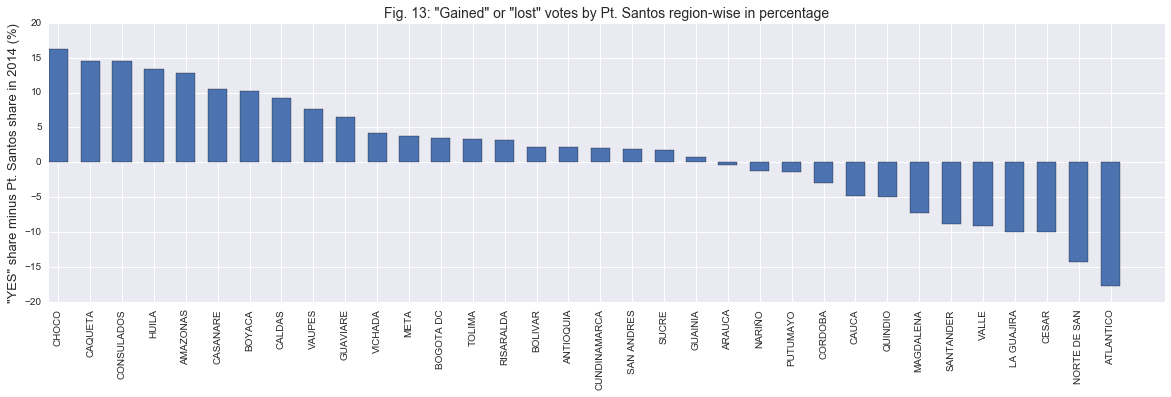

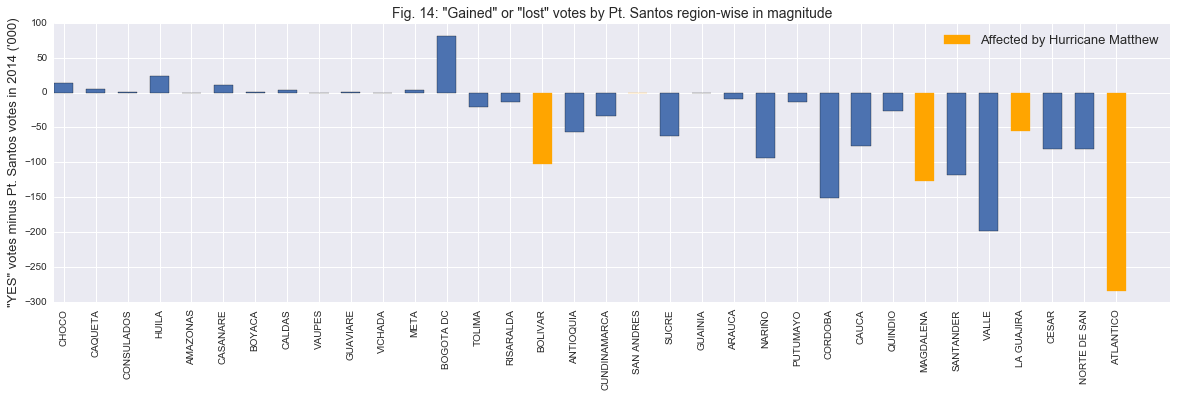

In [298]:
# Difference of "YES" participation and Pt. Santos voting share in 2014 (2nd round)
df_regions['delta_p'] = (df_regions['yes_votes_p']-df_regions['UN_votes_p14_2'])
temp = df_regions.loc[:,["delta_p"]]; temp['share'] = df_regions["voters"]/np.sum(df_regions['voters']);
temp['delta'] = (df_regions['yes_votes']-df_regions['UN_votes14_2'])/1e3
temp = temp.sort_values('delta_p',ascending = False)
# In percentage
part = temp['delta_p']
plt.figure(figsize=(20,5))
bar_plot1 = plt.bar(range(len(part)),part.values*100, 0.6); plt.xticks(np.arange(len(part))+0.3, part.index, rotation = 90);
plt.title('Fig. 13: "Gained" or "lost" votes by Pt. Santos region-wise in percentage', fontsize = 14)
plt.ylabel('"YES" share minus Pt. Santos share in 2014 (%)', fontsize = 13)
# In magnitude
dpts = ['ATLANTICO', 'LA GUAJIRA','SAN ANDRES','BOLIVAR', 'MAGDALENA']
part = temp['delta'];plt.figure(figsize=(20,5))
bar_plot1 = plt.bar(range(len(part)),part.values, 0.6); plt.xticks(np.arange(len(part))+0.3, part.index, rotation = 90);
[bar_plot1[i].set_color('orange') if df_regions.loc[v,'h_affect'] == 1 else '' for i,v in enumerate(part.index)];
bar_plot1[33].set_label('Affected by Hurricane Matthew')
plt.title('Fig. 14: "Gained" or "lost" votes by Pt. Santos region-wise in magnitude', fontsize = 14)
plt.ylabel('"YES" votes minus Pt. Santos votes in 2014 (\'000)', fontsize = 13); plt.legend(fontsize = 13);

From Figure 13 and 14, it can be noticed that while the majority of regions experienced a positive difference in percentage - like _CHOCO_ and _CAQUETA_ leading the "gained" votes ranking with roughly 15%, the additional voting share of those regions represented a little increment of votes in magnitude. On the contrary, regions with a negative difference in percentage represented a bigger fraction of the electoral vote base; thus, several thousands of votes were "lost" in those regions. These "lost" votes don't mean necessarily that people voted "NO", they also consider the lost votes due to the lower electoral participation rate - as mentioned before paticipation rate plummeted 8%. The latter could be the main reason of "lost" votes in the regions colored in orange where the pass of Hurricane Matthews affected civil infrastructure (see next section). For the other regions with high negative differences, why those votes were "lost" is an open question.

A conclusion so far is that **people's political affiliation played a crucial role in the outcome of the peace plebiscite at both regional and municipal level. _ATLANTICO_, _CORDOBA_ and _VALLE_ were the regions where Pt. Santos and the coalition parties lost the most votes compared to the second round of 2014 elections.**

## Did people actually vote?
Short answer: Not really!. Figure 15 shows the histogram and statistics of electoral participation at the municipal/city level. This dataset roughly fits to a normal distribution. **Approximately 21 million voters didn’t show up to the ballot, representing 75% of the electoral population**. The maximum participation rate was 62% and the minimum was 3%. To provide a reference, in the 2014 presidential elections the participation rate was about 40%. Several political analysts have associated this lackluster electoral participation with the low levels of popularity held by the current government. Another likely reason is the unfortunate effect of Hurricane Matthew in its journey near the North-cost during that weekend. 

To assess the likelihood of this meteorological event affecting the electoral participation rate, a dummy variable named `h_affect` is created to identify the regions and municipalities harmed by the footprint of Hurricane Matthew.

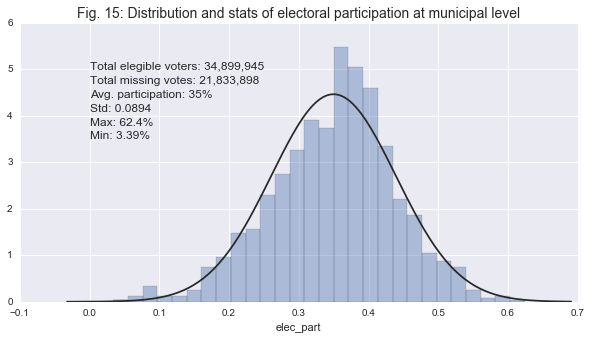

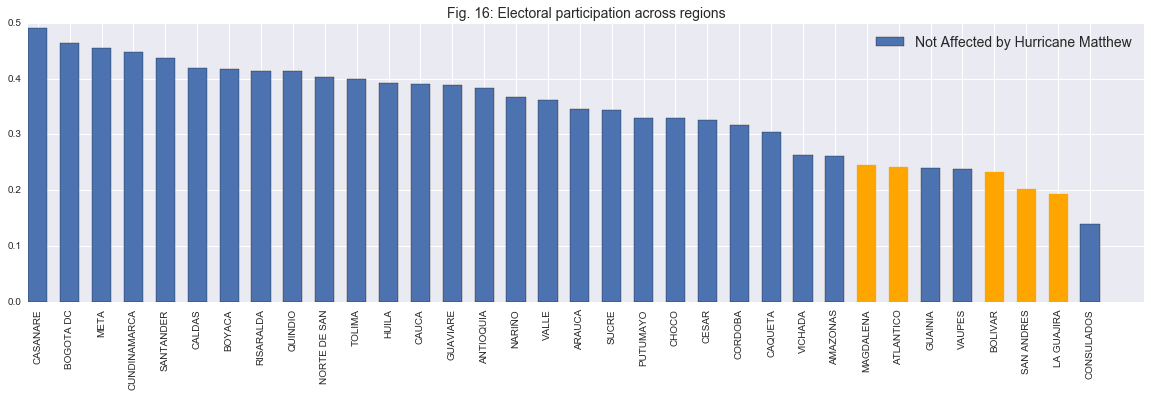

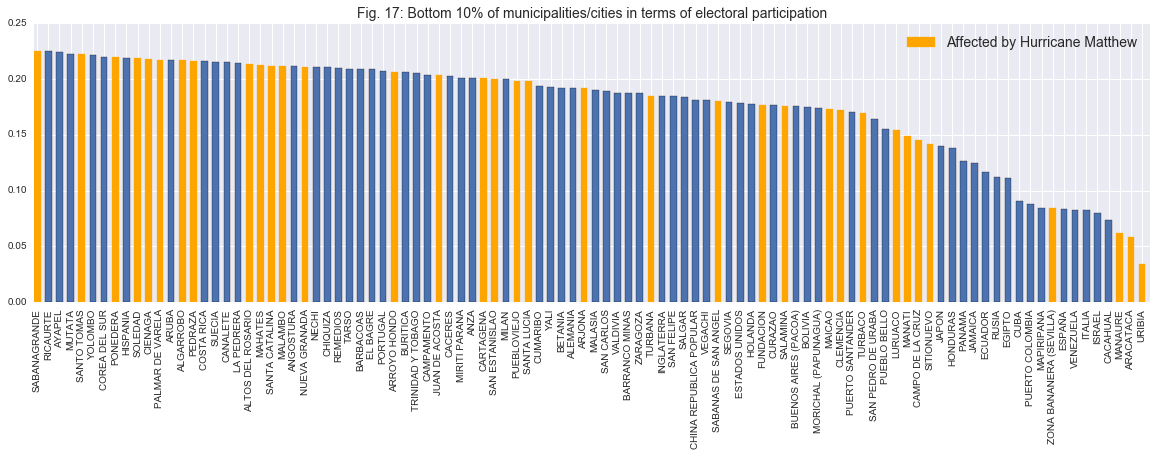

In [22]:
# Identifying regions affected by hurricane Matthew
dpts = ['ATLANTICO', 'LA GUAJIRA','SAN ANDRES','BOLIVAR', 'MAGDALENA']
df_regions['h_affect'] = [1 if i in dpts else 0 for i in df_regions.index]
df_munis['h_affect'] = [1 if i in dpts else 0 for i in df_munis['region']]

# Distribution of electoral participation
plt.figure(figsize=(10,5))
sns.distplot(df_munis["elec_part"],fit=norm, kde=False)
plt.title('Fig. 15: Distribution and stats of electoral participation at municipal level', fontsize = 14)
plt.text(0.0001,5,r'Total elegible voters: {:,}'.format(np.sum(df_regions['total_voters'])))
plt.text(0.0001,4.7,r'Total missing votes: {:,}'.format(np.sum(df_regions['total_voters']-df_regions['voters'])))
plt.text(0.0001,4.4,r'Avg. participation: {0:.3g}%'.format(np.mean(df_munis['elec_part'])*100))
plt.text(0.0001,4.1,r'Std: {0:.3g}'.format(np.std(df_munis['elec_part'])))
plt.text(0.0001,3.8,r'Max: {0:.3g}%'.format(np.max(df_munis['elec_part'])*100))
plt.text(0.0001,3.5,r'Min: {0:.3g}%'.format(np.min(df_munis['elec_part'])*100))

# Plot electoral participation across regions
part = df_regions["elec_part"]; part = part.sort_values(ascending = False)
plt.figure(figsize=(20,5))
bar_plot1 = plt.bar(range(len(part)),part.values, 0.6); plt.xticks(np.arange(len(part))+0.3, part.index, rotation = 90);
[bar_plot1[i].set_color('orange') if v in dpts else '' for i,v in enumerate(part.index)];
plt.legend(['Not Affected by Hurricane Matthew', "Affected by Hurricane Matthew"], fontsize = 14);
plt.title('Fig. 16: Electoral participation across regions', fontsize = 14)

# Bottom 10% of municipalities/cities in terms of electoral participation
part = df_munis["elec_part"]; part = part.sort_values(ascending = False)[-100:]
plt.figure(figsize=(20,5))
bar_plot1 = plt.bar(range(len(part)),part.values, 0.6); plt.xticks(np.arange(len(part))+0.3, part.index, rotation = 90);
[bar_plot1[i].set_color('orange') if df_munis.loc[v,'h_affect'] == 1 else '' for i,v in enumerate(part.index)];
plt.title('Fig. 17: Bottom 10% of municipalities/cities in terms of electoral participation', fontsize = 14)
plt.legend(["Affected by Hurricane Matthew"], fontsize = 14);

Figures 16 shows the electoral participation rate at the regional level in a descending order. Orange colored bars correspond to the areas affected by the hurricane. Noticeably, four out of the eight regions with the lowest participation were coastal regions likely blocked-off because of the hurricane. At the municipal level, Figure 17 presents the bottom 10% of municipalities in terms of participation. It can be noticed that impacted zones account for a big chunk as well. 

Additionally, the following table compares the participation rate in the peace plebiscite (`elec_part`) with the participation in the 2nd round of 2014 elections (`elec_part14_2`) for the affected regions. All these regions featured an ebbing participation rate; in some cases even greater than 15% (i.e. _ATLANTICO_ and _MAGDALENA_). The average electoral participation in these regions was _22%_ which contrasts with the _35%_ nationwide. This suggests that the hurricane could be the reason why regular voters didn't go to the ballot box during this election.

In [19]:
df_regions['elec_part14_2'] = df_regions['voters14_2']/df_regions['total_voters14_2']
df_regions['diff_elec'] = df_regions['elec_part'] - df_regions['elec_part14_2'] 
df_regions.loc[dpts,['elec_part','elec_part14_2','diff_elec']]

,elec_part,elec_part14_2,diff_elec
ATLANTICO,0.241017,0.414206,-0.173189
LA GUAJIRA,0.193937,0.331405,-0.137468
SAN ANDRES,0.202084,0.240453,-0.038369
BOLIVAR,0.233312,0.379683,-0.146371
MAGDALENA,0.244367,0.452317,-0.207950


This reduction in the voting mass most likely came as a lost for the "YES". The few votes gathered in the regions affected by the hurricane leaned in favor to the agreement, with a YES/NO ratio of _2.7x_ compared to the _1.8x_ elsewhere. Moreover, as Figure 14 shows, several thousands of votes were "lost" by Pt. Santos and the coalition parties in these regions relative to 2014, being _ATLANTICO_ the most noticeable region (about 250,000 lost votes).

**As a consequence, based on the data and given the slim difference between “YES” and “NO” votes, it could be argued that the Hurricane Mathew did have an effect in the electoral participation and such effect might in turn signified a tipping point in the final outcome of the plebiscite.**

Whatever the underlying reasons were for this drab participation rate, the fact is that it is rather disappointing and discouraging given the importance of what was at stake.

## Main takeaways
While a deeper study is required to further break-down these results, some conclusions can be drawn from the above analysis:
- Colombians rejected the peace agreement by a margin less than 0.2% of total votes. Even though on average the ratio of YES/NO votes was greater than one municipality-wise, positive votes weren't enough overall to outweigh negative votes.
- People living in _High_ and _Extreme_ vulnerable municipalities largely supported the peace agreement. Likewise, data shows a positive correlation between the YES/NO ratio and poverty rate region-wise.
- President Santos, and the pro-agreement parties, failed to convince more people to favorably vote the peace accord from 2014 until today. In fact, instead of gaining votes, they lost roughly 1.4 million votes overall to the "NO" answer and also due to the lower electoral participation rate (participation went down from 45% in 2014 to 37% this year).
- There is statistical evidence to argue that people's support or disapproval of Pt. Santos was a major decision factor in the final outcome of the peace plebiscite. In other words, the decision to vote "YES" or "NO" was highly biased towards the political stance of people with regards to Pt. Santos, rather than being a decision framed within the context of this particular agreement itself. This would entail that Pt. Santos and pro-agreement parties, especially the latter, did a poor job decoupling in people's minds this peace vote from the performance of the in-office government.
- ATLANTICO, CORDOBA and VALLE were the regions where Pt. Santos and the coalition parties lost the most votes compared to the second round of 2014 elections.
- Electoral participation was very low with a 63% of absence nationwide. 
- Data suggest that Hurricane Mathew did have a negative effect in this low participation rate, and it might entailed a turning point in the plebiscite’s outcome given thin margin of difference.

On a personal remark, I profoundly regret the outcome of the plebiscite since the decision taken by 50.21% of voters recklessly wager the fate of the people most affected by this grim conflict, hoping to force a re-negotiated agreement afterwards that makes FARC worse off - which is arguably their predominant motive over making the country better off. Since reaching a re-negotiated agreement was not, and still is not, a guaranteed possibility whatsoever, and considering that the ample majority of that 50.21% belongs to the 87% of population least vulnerable to the warfare, such decision rendered a striking moral hazard that I deeply hope won't deprive the most vulnerable Colombians from this life-changing opportunity.

How is any of this fair?. I really don't know. Fairness seems to be a scarce resource in my home country. A resource as unaffordable as the capacity of 63% of its eligible voters to turn up and mark an option.

As you read this tutorial, the Colombian government and FARC are sifting through the proposals submitted by opposition parties, seeking to incorporate them in a re-negotiated agreement. Colombians are eagerly awaiting for this process as a country loudly yelling that cannot bear this conflict any longer.

## References
- (In spanish) http://lasillavacia.com/silla-blanca
- https://internationaljusticeathunter.wordpress.com/2012/03/18/brief-summary-of-armed-conflict-in-colombia-3/
- https://www.washingtonpost.com/news/monkey-cage/wp/2016/10/01/sunday-colombians-vote-on-the-historic-peace-accord-with-the-farc-heres-what-you-need-to-know/
- https://www.wola.org/analysis/ending-50-years-of-conflict-in-colombia-a-new-report-from-wola/
- http://geopandas.org/